# Rumination prediction

### Imports

In [3]:
import os
import sys
import re
import glob
import ast
import os.path as op
import pickle
import mne
import scipy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx


# from inverse_covariance import (
#     QuicGraphicalLassoCV,
#     AdaptiveGraphicalLasso,
#     ModelAverage,
# )

from collections import defaultdict

from copy import deepcopy
import copy

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from autoreject import AutoReject

from transformers import *

import warnings
warnings.filterwarnings("ignore")

---
## Load data

Loading EEG data and data from rumination questionnaire. By default create_df_data loads all info from given file but one can specify it by passing a list of desired labels from csv file.

In [13]:
# paths TODO
dir_path = os.path.dirname(os.path.abspath(""))

In [14]:
tmin, tmax = -0.1, 0.6  # Start and end of the segments
signal_frequency = 256
random_state = 0

In [15]:
def create_df_data(
    test_participants=False,
    test_epochs=False,
    info_filename=None,
    info="all",
    personal=True,
):
    """Loads data for all participants and create DataFrame with optional additional info from given .csv file.

    On default, loads a train set: chooses only 80% of participants
    and for each of them chooses 80% of epochs.
    It will choose them deterministically.

    Participants with less than 10 epochs per condition are rejected.

    If test_participants is set to True, it will load remaining 20% of participants.
    If test_epochs is set to True, it will load remaining 20% of epochs.
    Test epochs are chronologically after train epochs,
    because it reflects real usage (first callibration and then classification).

    Parameters
    ----------
    test_participants: bool
        whether load data for training or final testing.
        If true load participants data for testing.
    test_epochs: bool
        whether load data for training or final testing.
        If true load epochs of each participants data for testing.
    info_filename: String | None
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters
    personal: bool
        whether a model will be both trained and tested on epochs from one person
        if false, person's epochs aren't split into test and train


    Returns
    -------
    go_nogo_data_df : pandas.DataFrame

    """
    print(os.path.abspath(""))
    dir_path = os.path.dirname(os.path.abspath(""))
    print(dir_path)
    header_files_glob = os.path.join(dir_path, "data/responses_100_600/*.vhdr")
    header_files = glob.glob(header_files_glob)

    header_files = sorted(header_files)
    go_nogo_data_df = pd.DataFrame()

    # cut 20% of data for testing
    h_train, h_test = train_test_split(header_files, test_size=0.3, random_state=0)
    
    print(f"train size: {len(h_train)} ; test size: {len(h_test)}")

    if test_participants:
        header_files = h_test
    else:
        header_files = h_train

    for file in header_files:
        #  load eeg data for given participant
        participant_epochs = load_epochs_from_file(file)

        # and compute participant's id from file_name
        participant_id = re.match(r".*_(\w+).*", file).group(1)

        error = participant_epochs["error_response"]._data
        correct = participant_epochs["correct_response"]._data

        # exclude those participants who have too few samples
        if len(error) < 5 or len(correct) < 5:
            # not enough data for this participant
            continue

        # construct dataframe for participant with: id|epoch_data|response_type|additional info...
        participant_df = create_df_from_epochs(
            participant_id, participant_epochs, info_filename, info
        )
        print(participant_id)
        go_nogo_data_df = go_nogo_data_df.append(participant_df, ignore_index=True)

    return go_nogo_data_df

In [5]:
def create_df_from_epochs(id, participant_epochs, info_filename, info):
    """Create df for each participant. DF structure is like: {id: String ; epoch: epoch_data ; marker: 1.0|0.0}
    1.0 means correct and 0.0 means error response.
    Default info extracted form .csv file is 'Rumination Full Scale' and participants' ids.
    With this info df structure is like:
    {id: String ; epoch: epoch_data ; marker: 1.0|0.0 ; File: id ; 'Rumination Full Scale': int}

    Parameters
    ----------
    id: String
        participant's id extracted from filename
    correct: array
        correct responses' data
    error: array
        error responses' data
    info_filename: String
        path to .csv file with additional data.
    info: array
        listed parameters from the info file to be loaded.
        if 'all', load all parameters

    Returns
    -------
    participant_df : pandas.DataFrame

    """
    participant_df = pd.DataFrame()
    info_df = pd.DataFrame()

    # get additional info from file
    if info_filename is not None:
        if info == "all":
            rumination_df = pd.read_csv(info_filename)
        else:
            rumination_df = pd.read_csv(info_filename, usecols=["Demo_kod"] + info)
        info_df = (
            rumination_df.loc[rumination_df["Demo_kod"] == id]
            .reset_index()
            .drop("index", axis=1)
        )      
    epoch_df = pd.DataFrame({"id": [id], "epoch": [participant_epochs]}).join(
            info_df
        )
    participant_df = participant_df.append(epoch_df, ignore_index=True)

    return participant_df

In [6]:
def load_epochs_from_file(file, reject_bad_segments="auto", mask=None):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)
        reject_bad_segments: 'auto' means that bad segments are rejected automatically.

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    event_dict = {
        "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
        "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
        "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
        "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
        "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
        "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
        "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
        "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    }

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct the original events from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        [10004, 10005, 10009, 10010],
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        [10006, 10007, 10008, 10011],
        merged_event_dict["error_response"],
        replace_events=True,
    )

    epochs = []
    bads = []
    this_reject_by_annotation = False
    
    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=this_reject_by_annotation,
        preload=True,
    )
    
    ar = AutoReject(random_state=random_state, n_jobs=10, verbose=0)
    epochs_ar, reject_log = ar.fit_transform(epochs, return_log=True)
    
    return epochs_ar

#### Read the data

In [7]:
df_name = "GNG_autoreject_3_5"
pickled_data_filename = "../data/" + df_name + ".pkl"
info_filename = "../data/scales/all_scales_with_rt_edited.csv"


# Check if data is already loaded
if os.path.isfile(pickled_data_filename):
    print("Pickled file found. Loading pickled data...")
    epochs_df = pd.read_pickle(pickled_data_filename)
    print("Done")
    pass
else:
    print("Pickled file not found. Loading data...")
    epochs_df = create_df_data(
        test_participants=False, info="all", personal=False, info_filename=info_filename
    )
    epochs_df.name = df_name
    # save loaded data into a pickle file
    epochs_df.to_pickle("../data/" + epochs_df.name + ".pkl")
    print("Done. Pickle file created")

Pickled file found. Loading pickled data...
Done


In [8]:
epochs_df

,id,epoch,Demo_kod,Pula badań,Płeć,Ręczność,Wiek,Dotychczasowa liczba lat edukacji,Wyznanie religijne,Wzrost w centymetrach,...,mean_post_fast_hit_RT,sd_post_fast_hit_RT,mean_post_slow_hit_RT,sd_post_slow_hit_RT,mean_post_error_RT,sd_post_error_RT,mean_post_inhibited_RT,sd_post_inhibited_RT,mean_post_error_RT_minus_mean_post_hit_RT,mean_post_error_RT_minus_mean_post_inhibited_response_RT
0,AS0401,"<Epochs | 228 events (all good), -0.101562 - ...",AS0401,2,0,1,23,15.0,katolicyzm,158.0,...,0.299272,0.055550,0.339358,0.071421,0.364094,0.104064,0.339048,0.063493,0.039212,0.025046
1,MK1711,"<Epochs | 268 events (all good), -0.101562 - ...",MK1711,2,0,1,23,16.0,katolicyzm,160.0,...,0.297397,0.054571,0.299366,0.062567,0.301527,0.079471,0.305890,0.073805,0.002861,-0.004364
2,KM0312,"<Epochs | 217 events (all good), -0.101562 - ...",KM0312,1,0,1,20,13.0,katolicyzm,NaN,...,0.327225,0.116620,0.304657,0.071612,0.345069,0.105712,0.315408,0.052246,0.031568,0.029661
3,IS0103,"<Epochs | 251 events (all good), -0.101562 - ...",IS0103,2,0,1,30,19.0,katolicyzm,168.0,...,0.351054,0.079689,0.383935,0.134537,0.402996,0.187194,0.390724,0.110189,0.032482,0.012272
4,MB0503,"<Epochs | 256 events (all good), -0.101562 - ...",MB0503,2,0,1,20,13.0,katolicyzm,168.0,...,0.263963,0.070721,0.282799,0.072330,0.306468,0.070277,0.330805,0.101310,0.034414,-0.024338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,AG1511,"<Epochs | 224 events (all good), -0.101562 - ...",AG1511,2,0,1,23,15.0,ateizm,159.0,...,0.328485,0.065219,0.342799,0.075012,0.341895,0.009583,0.372520,0.074904,0.006155,-0.030625
106,MA0706,"<Epochs | 246 events (all good), -0.101562 - ...",MA0706,1,1,1,40,25.0,katolicyzm,NaN,...,0.316877,0.056234,0.312559,0.053666,0.331681,0.046062,0.367330,0.096371,0.016430,-0.035650
107,JM0103,"<Epochs | 238 events (all good), -0.101562 - ...",JM0103,1,0,1,25,18.0,katolicyzm,NaN,...,0.323779,0.078497,0.348053,0.099744,0.374367,0.100070,0.365088,0.085367,0.031169,0.009279
108,MJ1306,"<Epochs | 247 events (all good), -0.101562 - ...",MJ1306,2,0,1,23,17.0,katolicyzm,165.0,...,0.297675,0.078336,0.306884,0.079258,0.337530,0.111130,0.358711,0.100038,0.036744,-0.021180


#### Read data for external testing

In [22]:
# df_name = "go_nogo_100_600_test_df_3-5_all_scales"
# pickled_data_filename = "../data/" + df_name + ".pkl"
# # info_filename = "../data/Demographic_Questionnaires_Behavioral_Results_N=163.csv"
# info_filename = "../data/scales/all_scales.csv"


# # Check if data is already loaded
# if os.path.isfile(pickled_data_filename):
#     print("Pickled file found. Loading pickled data...")
#     epochs_test_df = pd.read_pickle(pickled_data_filename)
#     print("Done")
# else:
#     print("Pickled file not found. Loading data...")
#     epochs_test_df = create_df_data(
#         test_participants=True, info="all", personal=False, info_filename=info_filename
#     )
#     epochs_test_df.name = df_name
#     # save loaded data into a pickle file
#     epochs_test_df.to_pickle("../data/" + epochs_test_df.name + ".pkl")
#     print("Done. Pickle file created")

## Create Net

#### Extract EEG features

1. PCA

In [306]:
timepoints_count = 181
spatial_filter_components = 4
bin_width = 12
roi = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

In [307]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

pipeline = Pipeline([
    ("channels_extraction",PickChannels(channels_list=roi)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
    ("spatial_filter",PCA(n_components=spatial_filter_components, random_state=random_state)),
    ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=timepoints_count)),
    ("lowpass_filter", LowpassFilter()),
    ("binning", BinTransformer(step=bin_width)),
    ("centering", CenteredSignalAfterBaseline3()),
    ("ern_data_extraction", ErnTransformer()),
    ("peak-to-peak", ErnAmplitude2()),
]).fit(epochs_df_copy)

preprocessed_X = pipeline.transform(epochs_df_copy)

preprocessed_X = preprocessed_X.reshape(preprocessed_X.shape[0], -1)

(110, 13, 181)
(110, 13, 181)


In [308]:
preprocessed_X.shape

(110, 4)

2. ERN

In [309]:
roi = [
    "Fz", 
]

In [310]:
epochs_df_copy = pd.DataFrame(copy.deepcopy(epochs_df.to_dict()))

pipeline = Pipeline([
   ("channels_extraction",PickChannels(channels_list=['Fz'])),
    ("trim", EpochTrim(tmin=0, tmax=0.1)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ("mean_amplitude", AverageSignal()),
    
]).fit(epochs_df_copy)

preprocessed_X_ern = pipeline.transform(epochs_df_copy)

preprocessed_X_ern = preprocessed_X_ern.reshape(preprocessed_X_ern.shape[0], -1)

IN PE RETURN SHAPE: (228, 1, 27)
(110, 1, 27)
IN PE RETURN SHAPE: (228, 1, 27)
(110, 1, 27)


In [311]:
preprocessed_X_ern.shape

(110, 1)

#### Extract questionnaires scores

Questionnaires to include in analysis

In [312]:
# shape 1-D: scores
rumination = "16-Rumination Full Scale"
dass_anxiety = "05-DASS-21 Anxiety scale"
stai_t = "04-STAI Trait SUM" 
bis = "07-BIS"
bas_dzialanie = "07-BAS Dzialanie"
bas_przyjemnosc = "07-BAS Poszukiwanie przyjemnosci"
bas_nagroda = "07-BAS Wrazliwosc na nagrode"
washing = "14-Obsessive-Compulsive WASHING"
obsessing = "14-Obsessive-Compulsive OBSESSING"
hoarding = "14-Obsessive-Compulsive HOARDING"
ordering = "14-Obsessive-Compulsive ORDERING"
checking = "14-Obsessive-Compulsive CHECKING"
neutralizing = "14-Obsessive-Compulsive NEUTRALIZING"
oci_r_full = "14-Obsessive-Compulsive FULL"
threat = "15-Obsessional Beliefs - Overestimation of threat"
perfectionism_IU = "15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty"
thought_suppression = "18-Thought Suppression Inventory"
nonforgivness = "22-Nonforgiveness - Full Scale"
indecisivness = "27-Indecisiveness Scale_Frost"
IU_prospecitve = "28-Intolerance of Uncertainty - Prospective Anxiety"
IU_inhibitory = "28-Intolerance of Uncertainty - Inhibitory Anxiety"
self_esteem = "06-Self-Esteem Scale_SES Rosenberga"

In [332]:
scales = [
    rumination,
    dass_anxiety,
    stai_t,
    bis,
    bas_dzialanie,
    bas_przyjemnosc,
    bas_nagroda,
    washing,
    obsessing,
    hoarding,
    ordering,
    checking,
    neutralizing,
    # oci_r_full,
    threat,
    perfectionism_IU,
    thought_suppression,
    IU_prospecitve,
    IU_inhibitory,
    self_esteem,
]

In [333]:
questionnaires_scores_df = epochs_df[scales]
questionnaires_scores_df.head()

,16-Rumination Full Scale,05-DASS-21 Anxiety scale,04-STAI Trait SUM,07-BIS,07-BAS Dzialanie,07-BAS Poszukiwanie przyjemnosci,07-BAS Wrazliwosc na nagrode,14-Obsessive-Compulsive WASHING,14-Obsessive-Compulsive OBSESSING,14-Obsessive-Compulsive HOARDING,14-Obsessive-Compulsive ORDERING,14-Obsessive-Compulsive CHECKING,14-Obsessive-Compulsive NEUTRALIZING,15-Obsessional Beliefs - Overestimation of threat,15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty,18-Thought Suppression Inventory,28-Intolerance of Uncertainty - Prospective Anxiety,28-Intolerance of Uncertainty - Inhibitory Anxiety,06-Self-Esteem Scale_SES Rosenberga
0,2.17,1.43,31,2.43,2.75,2.75,4.0,1.00,2.33,1.00,4.67,4.00,1.67,3.0,5.2,3.40,3.00,1.2,3.7
1,1.33,2.57,38,2.86,2.75,2.25,3.6,1.33,1.67,1.67,4.00,2.67,1.00,1.6,3.8,3.60,1.71,1.4,3.5
2,4.25,1.57,47,3.57,2.00,2.00,3.2,1.00,1.33,2.67,1.00,2.33,2.00,2.2,3.2,4.07,3.43,2.4,3.5
3,2.67,1.71,36,1.86,3.25,3.25,3.4,2.33,1.67,1.00,2.33,2.67,1.00,1.8,4.6,5.00,2.86,1.8,3.9
4,4.58,2.00,42,2.43,2.50,3.25,3.2,1.00,3.00,1.00,1.00,1.00,1.00,4.6,4.0,2.87,2.43,2.2,3.3


#### Concatenate questionnaire and EEG features

In [334]:
results_df = pd.DataFrame()

In [335]:
# add EEG features
eeg_columns = ['PCA_1', 'PCA_2', 'PCA_3', 'PCA_4']
eeg_columns_ern = ['ERN']
results_df[eeg_columns_ern] = preprocessed_X_ern
results_df[eeg_columns] = preprocessed_X

# add questionnaires
results_df = pd.concat([results_df, questionnaires_scores_df], axis=1)

results_df.head()

,ERN,PCA_1,PCA_2,PCA_3,PCA_4,16-Rumination Full Scale,05-DASS-21 Anxiety scale,04-STAI Trait SUM,07-BIS,07-BAS Dzialanie,...,14-Obsessive-Compulsive HOARDING,14-Obsessive-Compulsive ORDERING,14-Obsessive-Compulsive CHECKING,14-Obsessive-Compulsive NEUTRALIZING,15-Obsessional Beliefs - Overestimation of threat,15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty,18-Thought Suppression Inventory,28-Intolerance of Uncertainty - Prospective Anxiety,28-Intolerance of Uncertainty - Inhibitory Anxiety,06-Self-Esteem Scale_SES Rosenberga
0,-4.154519e-06,0.000014,0.000011,0.000002,1.703155e-06,2.17,1.43,31,2.43,2.75,...,1.00,4.67,4.00,1.67,3.0,5.2,3.40,3.00,1.2,3.7
1,-4.350181e-06,0.000007,0.000014,0.000001,9.100872e-07,1.33,2.57,38,2.86,2.75,...,1.67,4.00,2.67,1.00,1.6,3.8,3.60,1.71,1.4,3.5
2,-1.275030e-05,0.000045,0.000019,0.000004,6.033786e-06,4.25,1.57,47,3.57,2.00,...,2.67,1.00,2.33,2.00,2.2,3.2,4.07,3.43,2.4,3.5
3,2.483405e-07,0.000009,0.000008,0.000001,6.870822e-07,2.67,1.71,36,1.86,3.25,...,1.00,2.33,2.67,1.00,1.8,4.6,5.00,2.86,1.8,3.9
4,-2.718409e-06,0.000011,0.000019,0.000010,2.156309e-06,4.58,2.00,42,2.43,2.50,...,1.00,1.00,1.00,1.00,4.6,4.0,2.87,2.43,2.2,3.3


## Learn a graph structure

In [336]:
from sklearn import covariance

alphas = np.logspace(-1.5, 1, num=10)
edge_model = covariance.GraphicalLassoCV(
    alphas=alphas,
    cv=3,
    
)

# standardize the time series: using correlations rather than covariance
# former is more efficient for structure recovery

X = results_df.to_numpy()

X /= X.std(axis=0)
edge_model.fit(X)

GraphicalLassoCV(alphas=array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]),
                 cv=3)

Visualize covariance matrix

In [337]:
covariance_matrix_df = pd.DataFrame(edge_model.covariance_, columns = results_df.columns, index = results_df.columns)
precision_matrix_df = pd.DataFrame(edge_model.precision_, columns = results_df.columns, index = results_df.columns)

In [338]:
columns_dict = {
    "16-Rumination Full Scale": "RRQ",
    "05-DASS-21 Anxiety scale": "DASS-21 Anx",
    "04-STAI Trait SUM": "STAI-T",
    "07-BIS": "BIS",
    "14-Obsessive-Compulsive WASHING": "WASH",
    "14-Obsessive-Compulsive OBSESSING": "OBSESS",
    "14-Obsessive-Compulsive HOARDING": "HOARD",
    "14-Obsessive-Compulsive ORDERING": "ORD",
    "14-Obsessive-Compulsive CHECKING": "CHECK",
    "14-Obsessive-Compulsive NEUTRALIZING": "NEU",
    # "14-Obsessive-Compulsive FULL": "OCI-R",
    "15-Obsessional Beliefs - Overestimation of threat": "OT",
    "18-Thought Suppression Inventory": "WBSI",
    "28-Intolerance of Uncertainty - Prospective Anxiety": "IUS-P",
    "28-Intolerance of Uncertainty - Inhibitory Anxiety": "IUS-I",
    "06-Self-Esteem Scale_SES Rosenberga": "SES",
    "07-BAS Dzialanie": 'BAS_D',
    "07-BAS Poszukiwanie przyjemnosci": 'BAS_PRZY',
    "07-BAS Wrazliwosc na nagrode": 'BAS_NAG',
    "15-Obsessional Beliefs - Perfectionism/ Intolerance of uncertainty": 'OB_PERF',
    "22-Nonforgiveness - Full Scale": 'NONFOR',
    "27-Indecisiveness Scale_Frost": 'INDEC_F',
              }

In [339]:
precision_matrix_df = precision_matrix_df.rename(columns=columns_dict, index=columns_dict)
covariance_matrix_df = covariance_matrix_df.rename(columns=columns_dict, index = columns_dict)

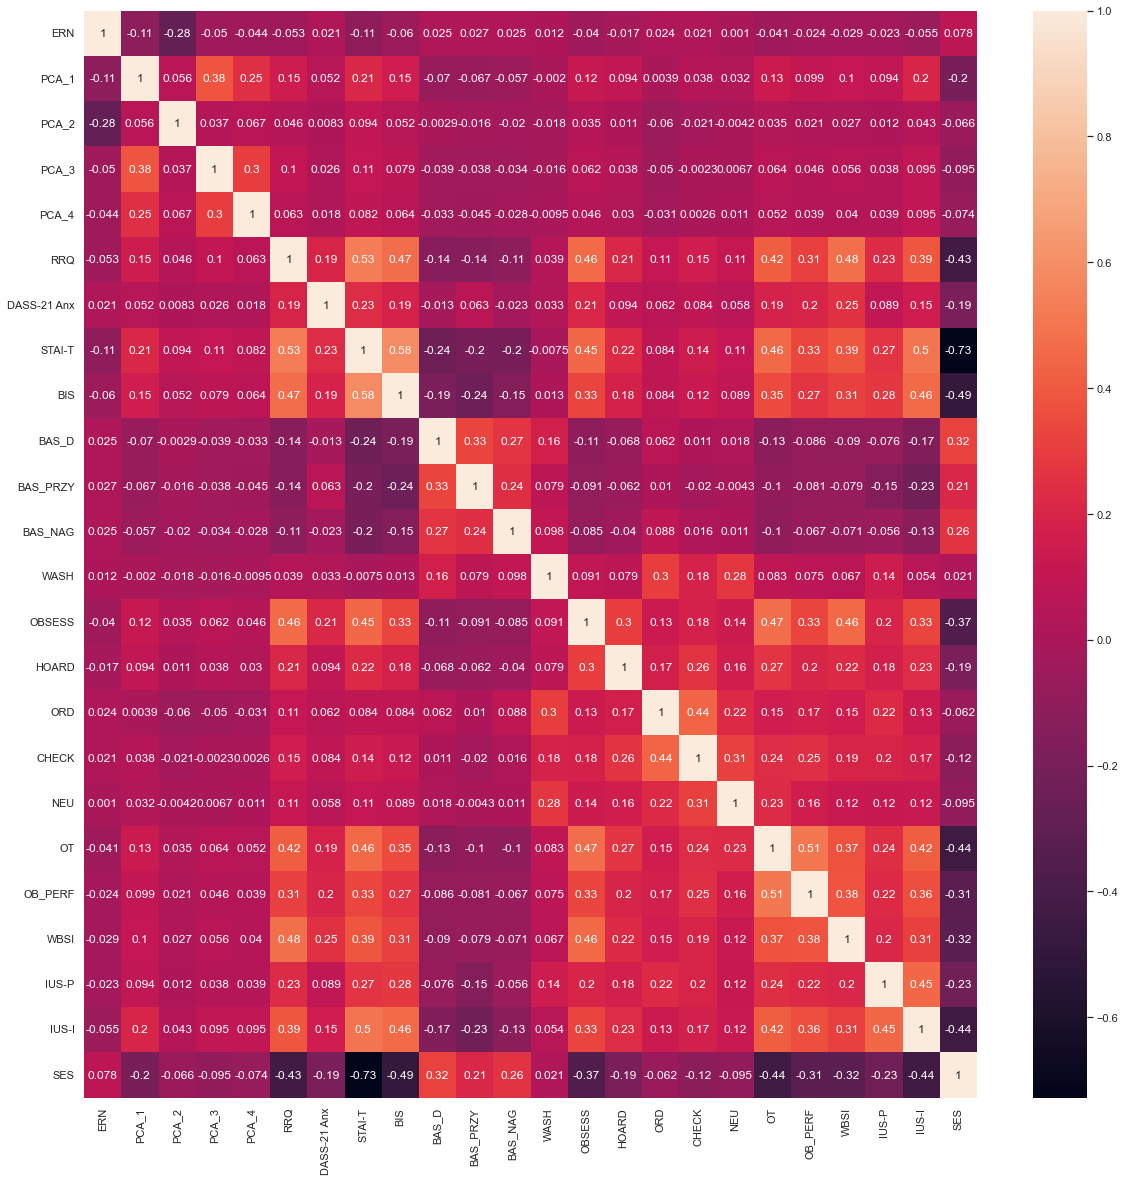

In [340]:
sns.set(rc={'figure.figsize':(20 , 20)})

fig = sns.heatmap(
    data = covariance_matrix_df,
    annot=True
)

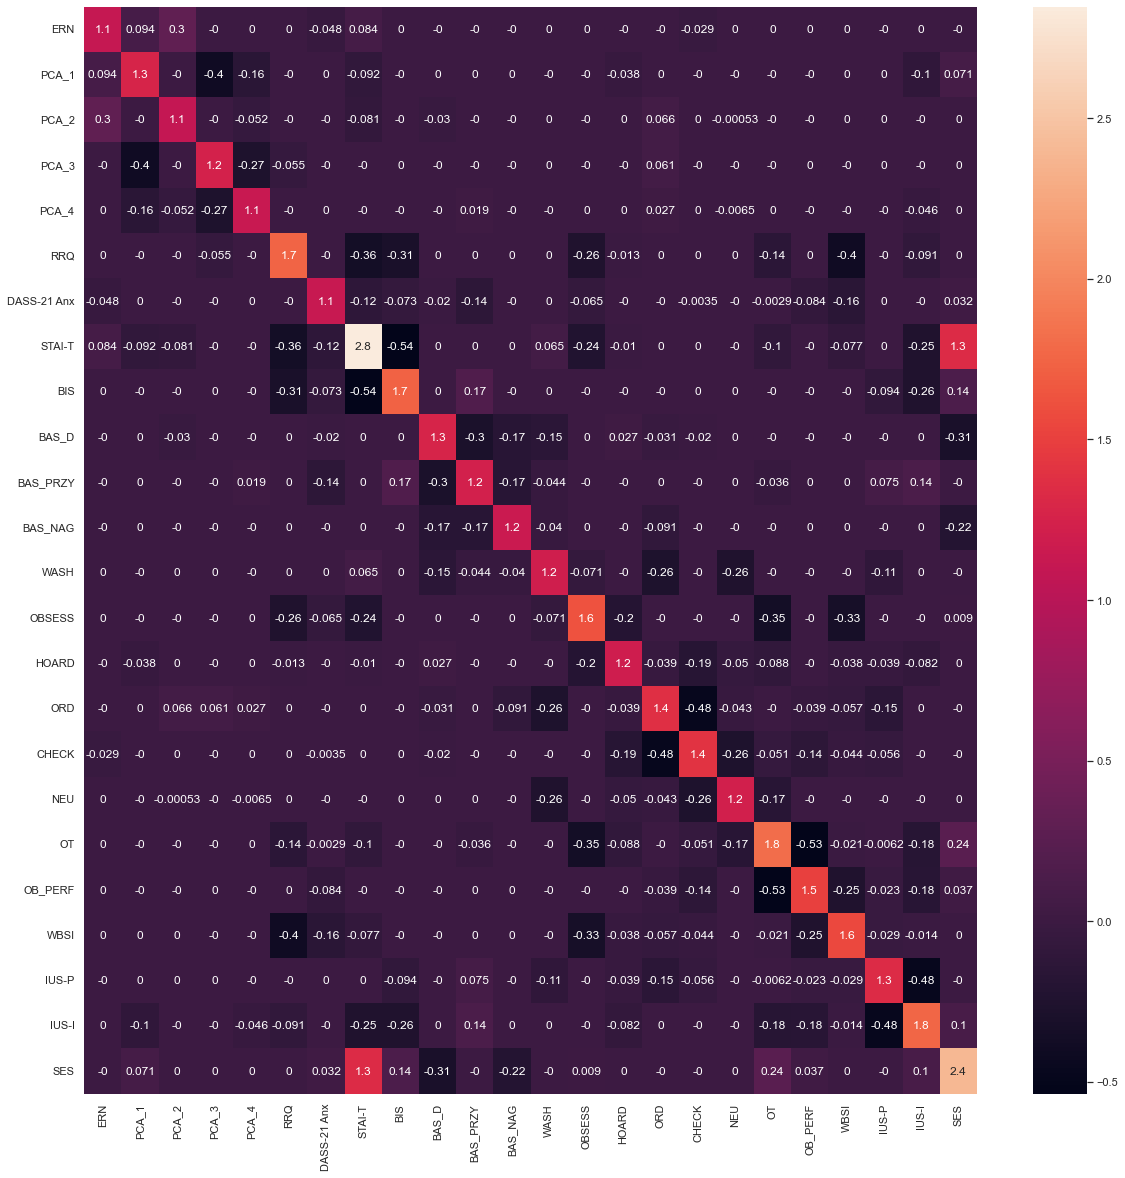

In [341]:
sns.set(rc={'figure.figsize':(20 , 20)})

fig = sns.heatmap(
    data = precision_matrix_df,
    annot=True
)

In [342]:
#prepare the matrix for network illustration
links = precision_matrix_df.stack().reset_index()
links.columns = ['var1', 'var2','weight']
links=links.loc[ (abs(links['weight']) > 0.05) &  (links['var1'] != links['var2']) ]

In [343]:
links = links.round(2)
links

,var1,var2,weight
1,ERN,PCA_1,0.09
2,ERN,PCA_2,0.30
7,ERN,STAI-T,0.08
24,PCA_1,ERN,0.09
27,PCA_1,PCA_3,-0.40
...,...,...,...
560,SES,BIS,0.14
561,SES,BAS_D,-0.31
563,SES,BAS_NAG,-0.22
570,SES,OT,0.24


In [344]:
#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'var1','var2', edge_attr='weight', create_using=nx.Graph())

In [354]:
pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=20)

In [357]:
pos = nx.circular_layout(G)

In [358]:
labels = nx.get_edge_attributes(G,'weight')

In [359]:
edges_list = list(zip(links.var1.to_list(), links.var2.to_list()))
edge_color = [('blue' if edge < 0 else 'red') for edge in links.weight.to_list()]

In [360]:
weights = links.weight.to_list()
weights_alphas = []
weight_bold = []

for edge_weight in weights:
    if abs(edge_weight) < 0.2:
        alpha = 0.2 
        bold = 4
    elif abs(edge_weight) >= 0.2 and abs(edge_weight) < 0.4:
        alpha = 0.4
        bold = 7
    elif abs(edge_weight) >= 0.4 and abs(edge_weight) < 0.7:
        alpha = 0.7
        bold = 10
    else:
        alpha = 0.9
        bold = 15
    weights_alphas.append(alpha)
    weight_bold.append(bold)

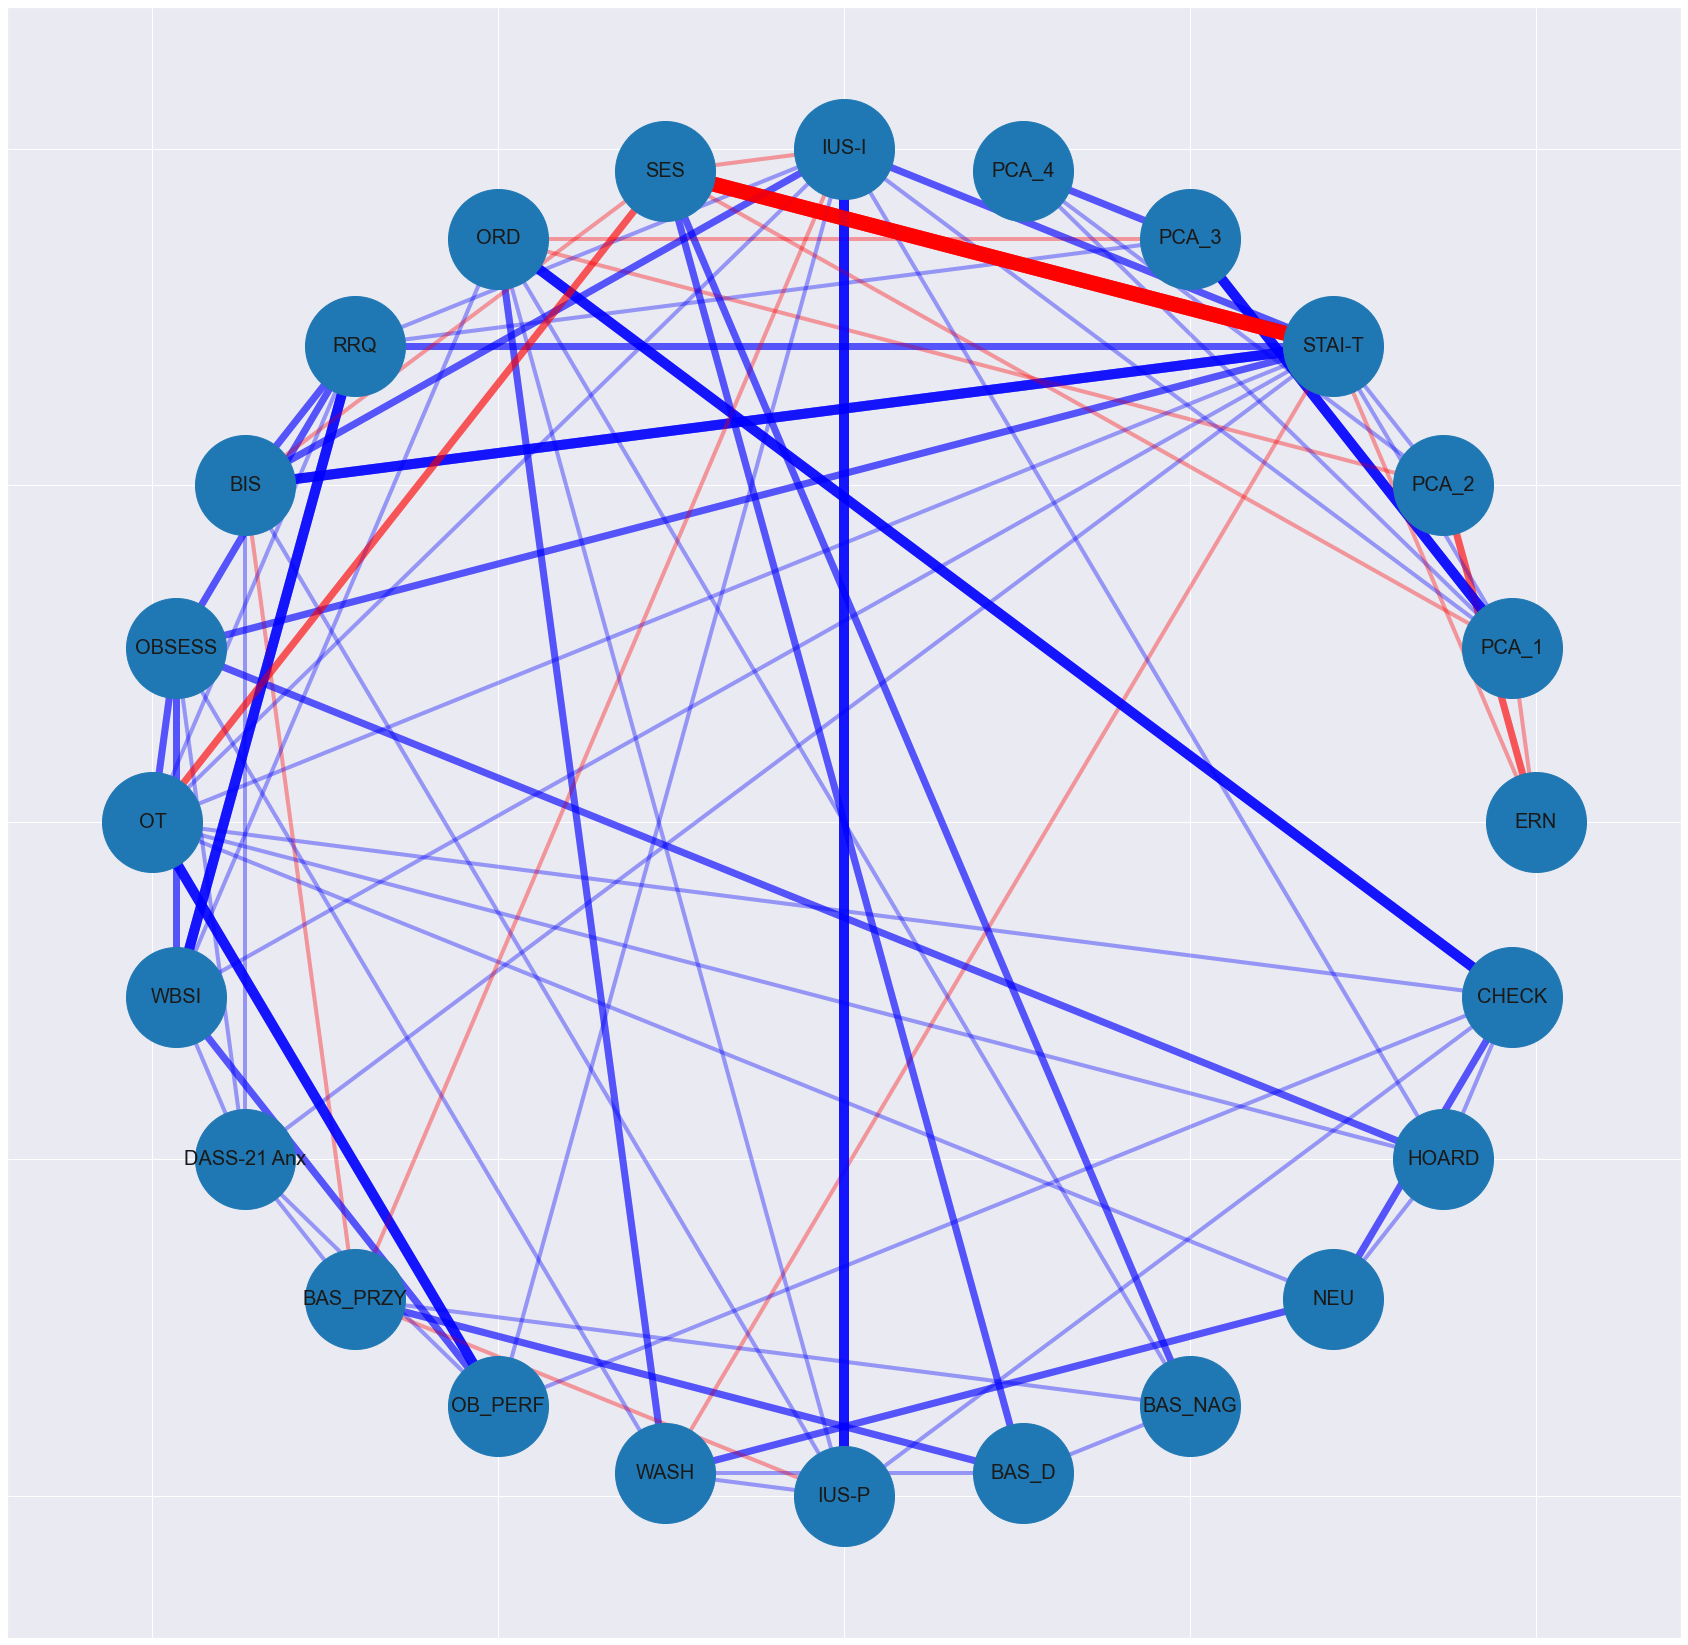

In [364]:
import matplotlib as mpl
plt.figure(3, figsize=(30, 30))



nx.draw_networkx_nodes(
    G, 
    pos=pos, 
    node_size = 10000,
)

nx.draw_networkx_labels(
    G, 
    pos=pos,
    font_size=20,

)

nx.draw_networkx_edges(
    G, 
    pos=pos,
    edgelist = edges_list,
    edge_color = edge_color,
    alpha=weights_alphas,
    width = weight_bold,
)

# nx.draw_networkx_edge_labels(
#     G, 
#     pos=pos, 
#     edge_labels=labels,
#     font_size=20,
# )
plt.show()

In [ ]:
# wider signal, ERN: -2,1 Pe: 1,6

import copy

results_baseline_100 = pd.DataFrame()

# manually test different numbers of spatial filter components

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

for box in box_list:
    
    X_train_df_copy = pd.DataFrame(copy.deepcopy(X_train_df.to_dict()))
    X_test_df_copy = pd.DataFrame(copy.deepcopy(X_test_df.to_dict()))

    print(f"----------BOX: {box}")

    for n_components in range(min_spatial_filter, 4, step_spatial_filter): 

        pipeline_name = f"PCA_{n_components}_baseline_100_0"

        ############################################################################################
        preprocessed_pipeline = Pipeline([
            ("channels_extraction",PickChannels(channels_list=box)),
            ("average", Evoked()),
            ('extract_averaged_data', ExtractData()),
            ("spatial_filter", SPoC(n_components=n_components, transform_into='csp_space')),
            ("lowpass_filter", LowpassFilter()),
            ('neg', ReverseComponent3()),
            ("binning", BinTransformer(step=12)),
            # ("baseline", ErnBaselined()),
            ("centering", CenteredSignalAfterBaseline3()) 

        ]).fit(X_train_df_copy, y_train)

        preprocessed_X = preprocessed_pipeline.transform(X_train_df_copy)

        ##########################################################################################

        ern_first_comp = Pipeline(steps=[
            # ("baseline", ErnBaselined()),
            ("ern_data_extraction", ErnTransformer()),
            ("get_first", GetComponent(0)),
            ("ern_peak_to_peak", ErnAmplitude2()),
        ])

        ern_second_comp = Pipeline(steps=[
            ("ern_data_extraction", ErnTransformer()),
            ("get_second", GetComponent(1)),
            ("diff_ern_peak", ErnAmplitude2_prim()),
        ])

        # ern_third_comp = Pipeline(steps=[
        #     ("ern_data_extraction", ErnTransformer(0,4)),
        #     ("get_third", GetComponent(2)),
        #     ("second_diff_ern_peak", ErnAmplitude2()),
        # ])

        ern_compo_features = FeatureUnion([("first", ern_first_comp), 
                                           ("second", ern_second_comp),
                                           # ("third", ern_third_comp),
                                          ],n_jobs = 10)


        ern_features = Pipeline(steps=[
                        # ("ern_data_extraction", ErnTransformer()),
                        # ("ern_amplitude", ErnAmplitude2()),
                        ("ern_compo_features", ern_compo_features),
                        ("data_channel_swap", ChannelDataSwap()),
                        ("postprocessing", PostprocessingTransformer()),
                        ("scaler", StandardScaler()),
                        # ("feature_extraction", FastICA(random_state=random_state))
        ])

        ####

        pe_first_comp = Pipeline(steps=[
            # ("baseline", ErnBaselined()),
            ("ern_data_extraction", PeTransformer(2,7)),
            ("get_first", GetComponent(0)),
            ("ern_peak_to_peak", PeAmplitude2()),
        ])

        pe_second_comp = Pipeline(steps=[
            ("ern_data_extraction", PeTransformer(3,8)),
            ("get_second", GetComponent(1)),
            ("diff_ern_peak", PeAmplitude2()),
        ])

        pe_third_comp = Pipeline(steps=[
            ("ern_data_extraction", PeTransformer(3,8)),
            ("get_third", GetComponent(2)),
            ("second_diff_ern_peak", PeAmplitude2()),
        ])

        pe_compo_features = FeatureUnion([("first", pe_first_comp), 
                                           ("second", pe_second_comp),
                                           ("third", pe_third_comp),
                                          ],n_jobs = 10)



        pe_features = Pipeline(steps = [
                        # ("pe_data_extraction", PeTransformer(start_pe_bin=ind[0], stop_pe_bin=ind[1])),
                        # ("pe_amplitude", PeAmplitude2()),
                        ("pe_compo_features", pe_compo_features),
                        ("data_channel_swap", ChannelDataSwap()),
                        ("postprocessing", PostprocessingTransformer()),
                        ("scaler", StandardScaler()),
                        # ("feature_extraction", FastICA(random_state=random_state))
        ])

        ern_pe_features = FeatureUnion([("ern_features", ern_features), ("pe_features", pe_features)], n_jobs = 10)

        steps = [('features', ern_pe_features)]
             
        ############################################################################################

        regressor_steps = steps

        # rate different models
        results_baseline_100 = run_experiment(
            tested_regressors,
            regressor_params,
            pipeline_name,
            preprocessed_X,
            X_test_df_copy,
            y_train,
            y_test,
            dataset_name,
            regressor_steps,
            preprocessed_pipeline,
            X_test_df_copy,
            results_baseline_100,
        )

In [ ]:
results_baseline_100.to_pickle("../data/regression_union_100-600_cached_splited_compos_ern-compo2-max_diff_models_no-fex_SPOC_mne.pkl")

In [30]:
box_3 = ["Fpz",
        "F1","Fz", "F2",
        "FC1", "FCz", "FC2",
        "C1","Cz","C2",
        "CP1", "CPz", "CP2",
        "P1","Pz", "P2",
]

box_4 = ["Fpz",
         "AFz",
        "F1","Fz", "F2",
        "FC1", "FCz", "FC2",
        "C1","Cz","C2",
        "CP1", "CPz", "CP2",
        "P1","Pz", "P2",
]

box_5 = ["F1","Fz", "F2",
        "FC1", "FCz", "FC2",
        "C1","Cz","C2",
        "CP1", "CPz", "CP2",
        "P1","Pz", "P2",
]

# linia i klaster z tyłu
red_box7 = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "Cz",
    "CPz",
    "P3", "P1", "Pz", "P2", "P4",
]

red_box7_prim = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "Cz",
    "CPz",
    "P1", "Pz", "P2",
]

# linia i klaster z tyłu i na środku
red_box8 = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "C3", "C1", "Cz","C2", "C4",
    "CPz",
    "P3", "P1", "Pz", "P2", "P4"
]

red_box8_prim = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

# linia i klaster z tyłu i na środku i na poczatku
red_box9 = [
    "Fpz", 
    "AFz",
    "F3", "F1", "Fz", "F2", "F4",
    "FCz",
    "C3", "C1", "Cz","C2", "C4",
    "CPz",
    "P3", "P1", "Pz", "P2", "P4",
]

red_box9_prim = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]



box_list = [red_box7_prim, red_box9_prim]

In [32]:
# define hyperparameters of pipeline
timepoints_count = 181

min_spatial_filter = 2
max_spatial_filter = 4
step_spatial_filter = 1

min_feature_selection = 3
max_feature_selection = 8
step_feature_selection = 1


# define proper parameters for training. In this case define range of number of feature extraction to search
regressor_params = dict(
#     features__feature_extraction__n_components=np.arange(
#         min_feature_selection, max_feature_selection, step_feature_selection
        
#     ),
    # features__channels_extraction__channels_list = box_list,
    
    # features__spatial_filter__n_components=np.arange(min_spatial_filter, max_spatial_filter, step_spatial_filter),
)

In [47]:
class EpochTrim2(TransformerMixin, BaseEstimator):
    def __init__(self, tmin=-0.1, tmax=1):
        super().__init__()
        self.tmin = tmin
        self.tmax = tmax

    def fit(self, X, y=None):
        return self

    def transform(self, X):

        X["epoch"] = X["epoch"].map(
            lambda x: x.crop(tmin=self.tmin, tmax=self.tmax)
        )

        # print(X.epoch[0])
        # print(X.epoch[0].get_data().shape)
        
        return X

In [ ]:
# define hyperparameters of pipeline
timepoints_count = 181

min_spatial_filter = 3
max_spatial_filter = 5
step_spatial_filter = 1

# min_feature_selection = 3
# max_feature_selection = 4
# step_feature_selection = 1


# define proper parameters for training. In this case define range of number of feature extraction to search
regressor_params = dict(
#     features__ern_features__feature_extraction__n_components=np.arange(
#         min_feature_selection, max_feature_selection, step_feature_selection
        
#     ),
    # spatial_filter__n_components=np.arange(min_spatial_filter, max_spatial_filter, step_spatial_filter),
)

In [ ]:
red_box = [
    "F3","F2", "F4",
    "C1","Cz", "FCz",
    "C3","C2","C4",
    "P1","Fpz", "P2",
    "P3", "CPz", "P4",
]

box_3 = ["Fpz",
        "F1","Fz", "F2",
        "FC1", "FCz", "FC2",
        "C1","Cz","C2",
        "CP1", "CPz", "CP2",
        "P1","Pz", "P2",
        ]
# bez Fpz - no significant
red_box2 = [
    "F3","F2", "F4",
    "C1","Cz", "FCz",
    "C3","C2","C4",
    "P1", "P2",
    "P3", "CPz", "P4",
]

# bez Fpz i z dodanym F1 - no sognificant
red_box3 = [
    "F3","F1","F2", "F4",
    "C1","Cz", "FCz",
    "C3","C2","C4",
    "P1", "P2",
    "P3", "CPz", "P4",
]

red_box4 = [
    "Fpz",
    "F3","F1","Fz", "F2", "F4",
    "FCz",
    "C3", "C1","Cz","C2","C4",
    "CPz",
    "P3", "P1", "P2", "P4",
]

red_box4_prim = [
    "Fpz",
    "F1","Fz", "F2",
    "FCz",
    "C1","Cz","C2",
    "CPz",
    "P1", "P2",
]

#
red_box5 = [
    "AFz", 
    "F3","F1","Fz", "F2", "F4",
    "C1","Cz", "FCz",
    "C3","C2","C4",
    "P1", "P2",
    "P3", "CPz", "P4",
]

red_box6 = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "Cz",
    "CPz",
    "Pz",
]

# linia i klaster z tyłu
red_box7 = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "Cz",
    "CPz",
    "P3", "P1", "Pz", "P2", "P4",
]

red_box7_prim = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "Cz",
    "CPz",
    "P1", "Pz", "P2",
]

# linia i klaster z tyłu i na środku
red_box8 = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "C3", "C1", "Cz","C2", "C4",
    "CPz",
    "P3", "P1", "Pz", "P2", "P4"
]

red_box8_prim = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

# linia i klaster z tyłu i na środku i na poczatku
red_box9 = [
    "Fpz", 
    "AFz",
    "F3", "F1", "Fz", "F2", "F4",
    "FCz",
    "C3", "C1", "Cz","C2", "C4",
    "CPz",
    "P3", "P1", "Pz", "P2", "P4",
]

red_box9_prim = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

red_box10 = [
    "Fpz", 
    "AFz",
    "F3", "F1", "Fz", "F2", "F4",
    "FCz",
    "Cz",
    "CP3", "CP1", "CPz", "CP2", "CP4",
    "Pz",
]

red_box10_prim = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "Cz",
    "CP1", "CPz", "CP2",
    "Pz",
]


# box_list = [red_box6, red_box7_prim, red_box8_prim, red_box9_prim, red_box10_prim, box_3]
box_list = [red_box7_prim, red_box9_prim]

### ERN

In [ ]:
# wider signal, ERN: -2,1 Pe: 1,6

import copy

results_ern_simple = pd.DataFrame()

# manually test different numbers of spatial filter components

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

this_bin=12

for scale in scales:
    print(f"---------------------SCALE: {scale}-------------------------")
    
    y_train = np.array(X_train_df[scale].to_list())
    y_test = np.array(X_test_df[scale].to_list())

    for box in box_list:

        X_train_df_copy = pd.DataFrame(copy.deepcopy(X_train_df.to_dict()))
        X_test_df_copy = pd.DataFrame(copy.deepcopy(X_test_df.to_dict()))

        print(f"----------BOX: {box}")

        for n_components in range(min_spatial_filter, max_spatial_filter, step_spatial_filter): 
            print(f"---------------------SPATIAL FILTER : {n_components}-------------------------")

            pipeline_name = f"PCA_{n_components}_scale_{scale}"

            ############################################################################################
            preprocessed_pipeline = Pipeline([
                ("channels_extraction",PickChannels(channels_list=box)),
                ("average", Evoked()),
                ('extract_averaged_data', ExtractData()),
                ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                ("spatial_filter",PCA(n_components=n_components, random_state=random_state)),
                ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=timepoints_count)),
                ("lowpass_filter", LowpassFilter()),
            ]).fit(X_train_df_copy)

            preprocessed_X = preprocessed_pipeline.transform(X_train_df_copy)

            ###########################################################################################

            ern_features = Pipeline(steps=[
                            ("ern_data_extraction", ErnTransformerTimepoints()),
                            ("ern_mean", AverageSignal()),
                            ("scaler", StandardScaler()),
                            # ("feature_extraction", FastICA(random_state=random_state))
            ])

            ern_pe_features = FeatureUnion([
                ("ern_features", ern_features), 
            ], n_jobs = 10)

            steps = [('features', ern_pe_features)]

            ############################################################################################

            regressor_steps = steps

            # rate different models
            results_ern_simple = run_experiment(
                tested_regressors,
                regressor_params,
                pipeline_name,
                preprocessed_X,
                X_test_df_copy,
                y_train,
                y_test,
                dataset_name,
                regressor_steps,
                preprocessed_pipeline,
                X_test_df_copy,
                scale,
                results_ern_simple,
            )

In [ ]:
results_ern_simple

In [ ]:
results_ern_simple.to_pickle("../data/regression_union_100-600_cached_ern_mean_various_scales.pkl")

### Pe

In [ ]:
red_box = [
    "F3","F2", "F4",
    "C1","Cz", "FCz",
    "C3","C2","C4",
    "P1","Fpz", "P2",
    "P3", "CPz", "P4",
]

box_3 = ["Fpz",
        "F1","Fz", "F2",
        "FC1", "FCz", "FC2",
        "C1","Cz","C2",
        "CP1", "CPz", "CP2",
        "P1","Pz", "P2",
        ]

box_3_prim = ["Fpz",
              "AFz",
        "F1","Fz", "F2",
        "FC1", "FCz", "FC2",
        "C1","Cz","C2",
        "CP1", "CPz", "CP2",
        "P1","Pz", "P2",
        ]

# bez Fpz - no significant
red_box2 = [
    "F3","F2", "F4",
    "C1","Cz", "FCz",
    "C3","C2","C4",
    "P1", "P2",
    "P3", "CPz", "P4",
]

# bez Fpz i z dodanym F1 - no sognificant
red_box3 = [
    "F3","F1","F2", "F4",
    "C1","Cz", "FCz",
    "C3","C2","C4",
    "P1", "P2",
    "P3", "CPz", "P4",
]

red_box4 = [
    "Fpz",
    "F3","F1","Fz", "F2", "F4",
    "FCz",
    "C3", "C1","Cz","C2","C4",
    "CPz",
    "P3", "P1", "P2", "P4",
]

red_box4_prim = [
    "Fpz",
    "F1","Fz", "F2",
    "FCz",
    "C1","Cz","C2",
    "CPz",
    "P1", "P2",
]

#
red_box5 = [
    "AFz", 
    "F3","F1","Fz", "F2", "F4",
    "C1","Cz", "FCz",
    "C3","C2","C4",
    "P1", "P2",
    "P3", "CPz", "P4",
]

red_box6 = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "Cz",
    "CPz",
    "Pz",
]

# linia i klaster z tyłu
red_box7 = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "Cz",
    "CPz",
    "P3", "P1", "Pz", "P2", "P4",
]

red_box7_prim = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "Cz",
    "CPz",
    "P1", "Pz", "P2",
]

# linia i klaster z tyłu i na środku
red_box8 = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "C3", "C1", "Cz","C2", "C4",
    "CPz",
    "P3", "P1", "Pz", "P2", "P4"
]

red_box8_prim = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

# linia i klaster z tyłu i na środku i na poczatku
red_box9 = [
    "Fpz", 
    "AFz",
    "F3", "F1", "Fz", "F2", "F4",
    "FCz",
    "C3", "C1", "Cz","C2", "C4",
    "CPz",
    "P3", "P1", "Pz", "P2", "P4",
]

red_box9_prim = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

red_box10 = [
    "Fpz", 
    "AFz",
    "F3", "F1", "Fz", "F2", "F4",
    "FCz",
    "Cz",
    "CP3", "CP1", "CPz", "CP2", "CP4",
    "Pz",
]

red_box10_prim = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "Cz",
    "CP1", "CPz", "CP2",
    "Pz",
]


# box_list = [red_box6, red_box7_prim, red_box8_prim, red_box9_prim, red_box10_prim, box_3]
box_list = [red_box8_prim, box_3, box_3_prim]

In [ ]:
# [Fpz, AFz, Fz, FCz, C1, Cz, C2, CPz, P1, Pz, P2]
# [Fpz, F1, Fz, F2, FC1, FCz, FC2, C1, Cz, C2, CP1, CPz, CP2, P1, Pz, P2]

In [ ]:
# wider signal, ERN: -2,1 Pe: 1,6

import copy

results_pe = pd.DataFrame()

# manually test different numbers of spatial filter components

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

this_bin=12

for scale in scales:
    print(f"---------------------SCALE: {scale}-------------------------")
    
    y_train = np.array(X_train_df[scale].to_list())
    y_test = np.array(X_test_df[scale].to_list())

    for box in box_list:

        X_train_df_copy = pd.DataFrame(copy.deepcopy(X_train_df.to_dict()))
        X_test_df_copy = pd.DataFrame(copy.deepcopy(X_test_df.to_dict()))

        print(f"----------BOX: {box}")

        for n_components in range(min_spatial_filter, max_spatial_filter, step_spatial_filter):
            print(f"---------------------SPATIAL FILTER : {n_components}-------------------------")

            pipeline_name = f"PCA_{n_components}_scale_{scale}"

            ############################################################################################
            preprocessed_pipeline = Pipeline([
                ("channels_extraction",PickChannels(channels_list=box)),
                ("average", Evoked()),
                ('extract_averaged_data', ExtractData()),
                ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
                ("spatial_filter",PCA(n_components=n_components, random_state=random_state)),
                ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=timepoints_count)),
                ("lowpass_filter", LowpassFilter()),
                # ('neg', ReverseComponent3()),
                ("binning", BinTransformer(step=this_bin)),
                ("baseline", ErnBaselined()),
                ("centering", CenteredSignalAfterBaseline3()) 

            ]).fit(X_train_df_copy)

            preprocessed_X = preprocessed_pipeline.transform(X_train_df_copy)

            ###########################################################################################

            # ern_features = Pipeline(steps=[
            #                 ("ern_data_extraction", ErnTransformer()),
            #                 ("ern_amplitude", ErnAmplitude2()),
            #                 ("data_channel_swap", ChannelDataSwap()),
            #                 ("postprocessing", PostprocessingTransformer()),
            #                 ("scaler", StandardScaler()),
            #                 # ("feature_extraction", FastICA(random_state=random_state))
            # ])


            pe_features = Pipeline(steps = [
                            ("pe_data_extraction", PeTransformer(3, 8)),
                            ("pe_amplitude", PeAmplitude2()),
                            ("data_channel_swap", ChannelDataSwap()),
                            ("postprocessing", PostprocessingTransformer()),
                            ("scaler", StandardScaler()),
                            # ("feature_extraction", FastICA(random_state=random_state))
            ])

            ern_pe_features = FeatureUnion([
                # ("ern_features", ern_features), 
                ("pe_features", pe_features)
            ], n_jobs = 10)

            steps = [('features', ern_pe_features)]

            ############################################################################################

            regressor_steps = steps

            # rate different models
            results_pe = run_experiment(
                tested_regressors,
                regressor_params,
                pipeline_name,
                preprocessed_X,
                X_test_df_copy,
                y_train,
                y_test,
                dataset_name,
                regressor_steps,
                preprocessed_pipeline,
                X_test_df_copy,
                scale,
                results_pe,
            )

In [ ]:
results_pe

In [ ]:
# define estimators and their hyperparameters

en = ("en", ElasticNet(random_state=random_state))
en_params = dict(
    en__alpha=np.logspace(-7, 3, num=20, base=10),
    en__l1_ratio=np.logspace(-8, 0, num=17, base=10),
)

kr = ("kr", KernelRidge(kernel="rbf"))
kr_params = dict(
    kr__alpha=np.logspace(-5, 3, num=20, base=10),
    kr__gamma=np.logspace(-5, 3, num=20, base=10),
)


svr = ("svr", SVR())
svr_params = dict(
    svr__kernel=["linear", "rbf"],
    svr__C=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10],
    svr__gamma=["scale"],
    svr__epsilon=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1],
)

tested_regressors = [
    (svr, svr_params), 
    (kr, kr_params), 
    (en, en_params)
]

In [ ]:
# define hyperparameters of pipeline
timepoints_count = 181

min_spatial_filter = 3
max_spatial_filter = 8
step_spatial_filter = 1

min_feature_selection = 2
max_feature_selection = 10
step_feature_selection = 1


# define proper parameters for training. In this case define range of number of feature extraction to search
regressor_params = dict(
    feature_extraction__n_components=np.arange(
        min_feature_selection, max_feature_selection, step_feature_selection
        
    ),
    spatial_filter__n_components=np.arange(min_spatial_filter, max_spatial_filter, step_spatial_filter),
)

In [ ]:
red_box = [
    "F3","F2", "F4",
    "C1","Cz", "FCz",
    "C3","C2","C4",
    "P1","Fpz", "P2",
    "P3", "CPz", "P4",
]

box_3 = ["Fpz",
        "F1","Fz", "F2",
        "FC1", "FCz", "FC2",
        "C1","Cz","C2",
        "CP1", "CPz", "CP2",
        "P1","Pz", "P2",
        ]
# bez Fpz - no significant
red_box2 = [
    "F3","F2", "F4",
    "C1","Cz", "FCz",
    "C3","C2","C4",
    "P1", "P2",
    "P3", "CPz", "P4",
]

# bez Fpz i z dodanym F1 - no sognificant
red_box3 = [
    "F3","F1","F2", "F4",
    "C1","Cz", "FCz",
    "C3","C2","C4",
    "P1", "P2",
    "P3", "CPz", "P4",
]

red_box4 = [
    "Fpz",
    "F3","F1","Fz", "F2", "F4",
    "FCz",
    "C3", "C1","Cz","C2","C4",
    "CPz",
    "P3", "P1", "P2", "P4",
]

red_box4_prim = [
    "Fpz",
    "F1","Fz", "F2",
    "FCz",
    "C1","Cz","C2",
    "CPz",
    "P1", "P2",
]

#
red_box5 = [
    "AFz", 
    "F3","F1","Fz", "F2", "F4",
    "C1","Cz", "FCz",
    "C3","C2","C4",
    "P1", "P2",
    "P3", "CPz", "P4",
]

red_box6 = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "Cz",
    "CPz",
    "Pz",
]

# linia i klaster z tyłu
red_box7 = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "Cz",
    "CPz",
    "P3", "P1", "Pz", "P2", "P4",
]

red_box7_prim = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "Cz",
    "CPz",
    "P1", "Pz", "P2",
]

# linia i klaster z tyłu i na środku
red_box8 = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "C3", "C1", "Cz","C2", "C4",
    "CPz",
    "P3", "P1", "Pz", "P2", "P4"
]

red_box8_prim = [
    "Fpz", 
    "AFz",
    "Fz",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

# linia i klaster z tyłu i na środku i na poczatku
red_box9 = [
    "Fpz", 
    "AFz",
    "F3", "F1", "Fz", "F2", "F4",
    "FCz",
    "C3", "C1", "Cz","C2", "C4",
    "CPz",
    "P3", "P1", "Pz", "P2", "P4",
]

red_box9_prim = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "C1", "Cz","C2",
    "CPz",
    "P1", "Pz", "P2",
]

red_box10 = [
    "Fpz", 
    "AFz",
    "F3", "F1", "Fz", "F2", "F4",
    "FCz",
    "Cz",
    "CP3", "CP1", "CPz", "CP2", "CP4",
    "Pz",
]

red_box10_prim = [
    "Fpz", 
    "AFz",
    "F1", "Fz", "F2",
    "FCz",
    "Cz",
    "CP1", "CPz", "CP2",
    "Pz",
]


box_list = [red_box6, red_box7_prim, red_box8_prim, red_box9_prim, red_box10_prim, box_3]
# box_list = [red_box10_prim, box_3]

In [ ]:
import copy

results_df = pd.DataFrame()

# manually test different numbers of spatial filter components

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

for scale in scales:
    print(f"---------------------SCALE: {scale}-------------------------")
    
    y_train = np.array(X_train_df[scale].to_list())
    y_test = np.array(X_test_df[scale].to_list())
    
    for box in box_list:

        X_train_df_copy = pd.DataFrame(copy.deepcopy(X_train_df.to_dict()))
        X_test_df_copy = pd.DataFrame(copy.deepcopy(X_test_df.to_dict()))

        print(f"BOX: {box}")

        # for n_components in range(min_spatial_filter, max_spatial_filter, step_spatial_filter): 

        pipeline_name = f"PCA_plain_{scale}"

        ##########################################

        preprocessed_pipeline = Pipeline([    
        ("channels_extraction",PickChannels(channels_list=box)),
        ("average", Evoked()),
        ('extract_averaged_data', ExtractData()),
        ]).fit(X_train_df_copy)

        preprocessed_X = preprocessed_pipeline.transform(X_train_df_copy)

        ############################################################################################

        steps = [
            ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
            ("spatial_filter",PCA(random_state=random_state)),
            ("spatial_filter_postprocessing",SpatialFilterPostprocessing(timepoints_count=timepoints_count)),
            ("lowpass_filter", LowpassFilter()),
            # ('neg', ReverseComponent3()),
            ("binning", BinTransformer(step=12)),
            ("baseline", ErnBaselined()),
            # ("centering", CenteredSignalAfterBaseline3()),
            ("data_channel_swap", ChannelDataSwap()),
            ("postprocessing", PostprocessingTransformer()),
            ("scaler", StandardScaler()),
            ("feature_extraction", FastICA(random_state=random_state))
        ]

        ############################################################################################

        regressor_steps = steps

        # rate different models
        results_df = run_experiment(
            tested_regressors,
            regressor_params,
            pipeline_name,
            preprocessed_X,
            X_test_df_copy,
            y_train,
            y_test,
            dataset_name,
            regressor_steps,
            preprocessed_pipeline,
            X_test_df_copy,
            results_df,
        )

In [ ]:
# results_df.to_pickle("../data/regression_union_100-600_cached_plain_pca_various_traits.pkl")

In [ ]:
# results_df

In [ ]:
# not work (possibly due to MNE printing messages that fill up RAM)

import copy

results_df_spoc = pd.DataFrame()

# manually test different numbers of spatial filter components

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore" # Also affect subprocesses

# for box in box_list:

    X_train_df_copy = pd.DataFrame(copy.deepcopy(X_train_df.to_dict()))
    X_test_df_copy = pd.DataFrame(copy.deepcopy(X_test_df.to_dict()))
    
    # print(f"BOX: {box}")

for n_components in range(min_spatial_filter, max_spatial_filter, step_spatial_filter): 

    pipeline_name = f"SPoC_{n_components}_plain"

    ############################################################################################

    preprocessed_pipeline = Pipeline([    
    # ("channels_extraction",PickChannels(channels_list=box)),
    ("average", Evoked()),
    ('extract_averaged_data', ExtractData()),
    ]).fit(X_train_df_copy)

    preprocessed_X = preprocessed_pipeline.transform(X_train_df_copy)

    ############################################################################################

    steps = [
        ("spatial_filter", SPoC(n_components=n_components, transform_into='csp_space')),
        ("lowpass_filter", LowpassFilter()),
        ("binning", BinTransformer(step=12)),
        # ("baseline", ErnBaselined()),
        # ("centering", CenteredSignalAfterBaseline3()),
        ("data_channel_swap", ChannelDataSwap()),
        ("postprocessing", PostprocessingTransformer()),
        ("scaler", StandardScaler()),
        ("feature_extraction", FastICA(random_state=random_state))
    ]

    ############################################################################################

    regressor_steps = steps

    # rate different models
    results_df_spoc = run_experiment(
        tested_regressors,
        regressor_params,
        pipeline_name,
        preprocessed_X,
        X_test_df_copy,
        y_train,
        y_test,
        dataset_name,
        regressor_steps,
        preprocessed_pipeline,
        X_test_df_copy,
        results_df_spoc,
    )

In [ ]:
results_df_spoc

In [ ]:
# data_df = pd.read_pickle(
#     "../data/split0.3/regression_union_100-600_baselined_centered_ampl-2-pe-ern_0.3-5_significant.pkl"
# )
data_df = results_static_ICA_bin_union_100_600_baselined_peak_to_peak_components_df
data_df.name = "union_100_600_baselined_centered_no_scaler"

In [ ]:
data_df

#### Extract coefficients of ERN and PE features extraction (ICA) and coefficient od estimator

In [ ]:
# ern_features = data_df.best_estimator[1]["features"].transformer_list[0][1]["feature_selection"].components_
# pe_features = data_df.best_estimator[1]["features"].transformer_list[1][1]["feature_selection"].components_

# without additional metric as feature
ern_features = data_df.best_estimator[0]["features"]["ern_pe_features"].transformer_list[0][1]["feature_selection"].components_
pe_features = data_df.best_estimator[0]["features"]["ern_pe_features"].transformer_list[1][1]["feature_selection"].components_

coeffs = data_df.best_estimator[0]["en"].coef_

In [ ]:
ern_features.shape

In [ ]:
pe_features.shape

In [ ]:
coeffs

#### Weigh components with coeffs from estimator and sum

In [ ]:
ern_components_weighed = np.array([ern_features[i] * coeffs[i] for i in range(0,ern_features.shape[0])])
pe_components_weighed = np.array([pe_features[i-ern_features.shape[0]] * coeffs[i] for i in range(ern_features.shape[0], ern_features.shape[0] + pe_features.shape[0])])

#### Sum all feature extraction components to extract direct weigh of given bin at given spatial filter component

In [ ]:
components_weighed_ern_sum = sum(ern_components_weighed)
components_weighed_pe_sum = sum(pe_components_weighed)

In [ ]:
components_weighed_ern_sum

In [ ]:
mean_rum_ern = components_weighed_ern_sum * ern_ampl_mean
mean_rum_ern

In [ ]:
mean_rum_pe = components_weighed_pe_sum * pe_ampl_mean
mean_rum_pe

#### Extract components of spatial filter

In [ ]:
ern_features = Pipeline(steps=[
                ("ern_data_extraction", ErnTransformer()),
                ("ern_amplitude", ErnAmplitude2()),
                ("data_channel_swap", ChannelDataSwap()),
                ("postprocessing", PostprocessingTransformer()),
                ("scaler", StandardScaler()),
                # ("feature_selection", FastICA(random_state=random_state))
])


pe_features = Pipeline(steps = [
                ("pe_data_extraction", PeTransformer()),
                # ("pe_centered", CenteredPeAfterBaseline()),
                ("pe_amplitude", PeAmplitude2()),
                ("data_channel_swap", ChannelDataSwap()),
                ("postprocessing", PostprocessingTransformer()),
                # ("scaler", StandardScaler()),
                # ("feature_selection", FastICA(random_state=random_state))
])

ern_pe_features = FeatureUnion([("ern_features", ern_features), ("pe_features", pe_features)], n_jobs = 10)

features = Pipeline([
    ('ern_pe_features', ern_pe_features)

])

# steps = ('features', features)

preprocessed_pipeline = Pipeline([("extract_epochs", EEGdata(dataset=dataset)),
    # ("narrow_indices", NarrowIndices(start=76, stop=257)),
    (
        "channels_filtering",
        ChannelExtraction(significant_channels)
    ),
    (
        "average_epochs",
        AveragePerParticipant(),
    ),
    ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
    (
        "spatial_filter",
        PCA(n_components=3, random_state=random_state),
    ),
    (
        "spatial_filter_postprocessing",
        SpatialFilterPostprocessing(
            timepoints_count=181,
        ),
    ),
    ("lowpass_filter", LowpassFilter()),
    ("binning", BinTransformer(step=12)),
    ("baseline", ErnBaselined()),
    ("centering", CenteredSignalAfterBaseline()),
    # ('features', features)

                          ]).fit(X_train)
preprocessed_X_test = preprocessed_pipeline.transform(X_test_df)

In [ ]:
preprocessed_X = preprocessed_pipeline.transform(X_train)

In [ ]:
preprocessed_X.shape

In [ ]:
pe_ampl = preprocessed_X[:,3:6]
pe_ampl_mean = np.mean(pe_ampl, axis=0)
pe_ampl_mean

In [ ]:
ern_ampl = preprocessed_X[:,0:3]
ern_ampl_mean = np.mean(ern_ampl, axis=0)

In [ ]:
ern_ampl_mean

In [ ]:
# steps = ('features', features)
preprocessed_pipeline = Pipeline([("extract_epochs", EEGdata(dataset=dataset)),
            # ("narrow_indices", NarrowIndices(start=76, stop=257)),
            (
                "channels_filtering",
                ChannelExtraction(significant_channels)
            ),
            (
                "average_epochs",
                AveragePerParticipant(),
            ),
            ("spatial_filter_preprocessing", SpatialFilterPreprocessing()),
            (
                "spatial_filter",
                PCA(n_components=3, random_state=random_state),
            ),
            (
                "spatial_filter_postprocessing",
                SpatialFilterPostprocessing(
                    timepoints_count=181,
                ),
            ),
            ("lowpass_filter", LowpassFilter()),
            ("binning", BinTransformer(step=12)),
            ("baseline", ErnBaselined()),
            ("centering", CenteredSignalAfterBaseline()),
            ('ern_pe_features', ern_pe_features)
                                  ]).fit(X_train)

preprocessed_X = preprocessed_pipeline.transform(X_train)
pre_processed_test_X = preprocessed_pipeline.transform(X_test_df)

In [ ]:
# ern_features = Pipeline(steps=[
#                     ("ern_extraction", CenteredERN(step=16)),
#                     ("binning", BinTransformer(step=16)),
# #                     ("data_channel_swap", ChannelDataSwap()),
# #                     ("postprocessing", PostprocessingTransformer()),
# #                     ("scaler", StandardScaler()),
# #                     ("feature_selection", FastICA(random_state=random_state))
# # 
# ])

# pe_features = Pipeline(steps = [
#                         ("pe_extraction", CenteredPe(step=16)),
#                         ("binning", BinTransformer(step=16)),
# #                         # ("data_channel_swap", ChannelDataSwap()),
# #                         # ("postprocessing", PostprocessingTransformer()),
# #                         # ("scaler", StandardScaler()),
# #                         # ("feature_selection", FastICA(random_state=random_state))
#         ])
    
# #         ern_pe_features = FeatureUnion([("ern_features", ern_features), ("pe_features", pe_features)], n_jobs = 10)

# #         features = Pipeline([
# #             ('ern_pe_features', ern_pe_features)

# #         ])

# #         steps = ('features', features)

# ern_fitted = ern_features.fit_transform(preprocessed_X)
# ern_test_fitted = ern_features.transform(pre_processed_test_X)

In [ ]:
ern_fitted_mean = np.mean(ern_fitted, axis=0)
ern_test_fitted_mean = np.mean(ern_test_fitted, axis=0)

In [ ]:
ern_test_fitted_mean.shape

In [ ]:
import matplotlib.pyplot as plt

plt.plot(ern_fitted_mean[0])

---

In [ ]:
spatial_filter_n_components = 3

this_steps = spatial_filter_bins_steps(spatial_filter_n_components=spatial_filter_n_components, timepoints_count=181)
pre_processed_X = Pipeline(steps=this_steps).fit_transform(X_train)

In [ ]:
pre_processed_test_X = preprocessed_pipeline.transform(X_test_df)
pre_processed_X = preprocessed_pipeline.transform(X_train)

In [ ]:
# Averaged signal within components through all participants
mean_X_1 = np.mean(pre_processed_X, axis=0)

In [ ]:
ern_fitted.shape

In [ ]:
mean_X.shape

In [ ]:
pre_processed_test_X.shape

In [ ]:
# Averaged signal within components through all participants
mean_X = np.mean(preprocessed_X, axis=0)
mean_2_X = np.mean(pre_processed_test_X, axis=0)

-----
### Plot results

In [ ]:
# indices in bins

tmin, tmax = -0.1, 0.6  # Start and end of the segments
signal_frequency = 256

step_in_ms = 50  # in miliseconds (?)
step_tp = int(signal_frequency * step_in_ms / 1000) # in timepoints

# indices for slicing epoch into ERN part and Pe part (in sec)
start_ern = 0
stop_ern = 0.15
start_pe = 0.15
stop_pe = 0.35

start_ern_bin = int((signal_frequency * (start_ern - tmin)) / step_tp) + 1
stop_ern_bin = int(signal_frequency * (stop_ern - tmin) / step_tp) + 1
start_pe_bin = int(signal_frequency * (start_pe - tmin) / step_tp) + 1
stop_pe_bin = int(signal_frequency * (stop_pe - tmin) / step_tp) + 1

In [ ]:
start_ern_bin = 0
stop_ern_bin = 3
start_pe_bin = 3
stop_pe_bin = 7

In [ ]:
spatial_filter_n_components = 3

In [ ]:
# 0, 1 or 2
this_component = 2

# pe_step = int(pe_features.shape[1]/ spatial_filter_n_components)
# ern_step = int(ern_features.shape[1]/ spatial_filter_n_components)
# spatial_filter_step = int(pre_processed_X.shape[1]/3)

In [ ]:
spatial_filter_step

In [ ]:
ern_components_weighed.shape

In [ ]:
-ern_fitted_mean[0]

In [ ]:
ern_components_weighed[0][0:3].shape

In [ ]:
np.arange(0,4).shape

In [ ]:
import seaborn as sns
import matplotlib.pylab as plt

sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("white")

fig, ax1 = plt.subplots()

# ax1 = plt.twinx()
ax1.set(ylim=(np.min(ern_components_weighed)-0.1, np.max(pe_components_weighed)+0.05))
ax1.tick_params(axis='y', color="magenta", width=3, length=10)

plt.axhline(y=0, color="grey", linewidth = 2, linestyle='--', alpha=0.5)
plt.axvline(x=2, color="grey", linewidth = 2, linestyle='--', alpha=0.5)
plt.axvline(x=6, color="grey", linewidth = 2, linestyle='--', alpha=0.5)



# for i in range(0,5):
#     sns.lineplot(np.arange(0,3), ern_components_weighed[i][this_component:3], ax=ax1)

# for i in range(0,pe_features.shape[0]):
#     sns.scatterplot(np.arange(5,6), pe_components_weighed[i][this_component], ax=ax1)
    

ax2 = plt.twinx()
ax2.set(ylim=(-1e-5,2.5e-5))
ax2.tick_params(axis='y', color="black")

# ax3 = plt.twinx()
# ax3.set(ylim=(min(components_weighed_ern_sum), max(components_weighed_ern_sum)))
# ax3.tick_params(axis='y', color="magenta")

sns.scatterplot(x=[4], y= components_weighed_pe_sum[this_component], ax=ax1, color="magenta")
sns.scatterplot(x=[1], y= components_weighed_ern_sum[this_component], ax=ax1, color="magenta")
# sns_plot = sns.scatterplot(np.arange(5,6), components_weighed_pe_sum[this_component*pe_step:(this_component+1)*pe_step], ax=ax1, color="magenta")
# plt.axhline(y=0, color="magenta", linewidth = 2)

sns_plot = sns.lineplot(np.arange(0,10), -mean_X[this_component], ax=ax2, color="black", linewidth = 3)


sns_plot.figure.savefig(f"{data_df.name}_output_{this_component}.png")

In [ ]:
np.mean(y_train)

In [ ]:
np.mean(y_rum)